In [13]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import librosa, librosa.display

from maad import sound, rois, features
from maad.util import (power2dB, plot2d, format_features, read_audacity_annot,
                       overlay_rois, overlay_centroid)

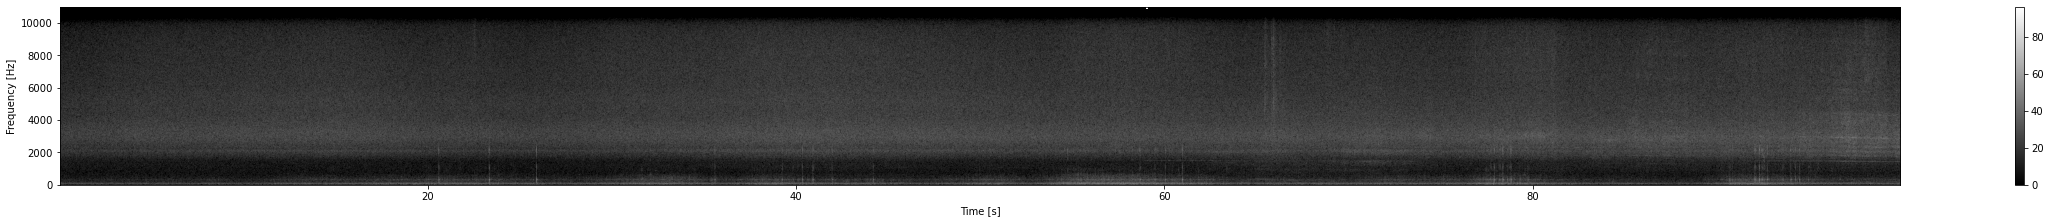

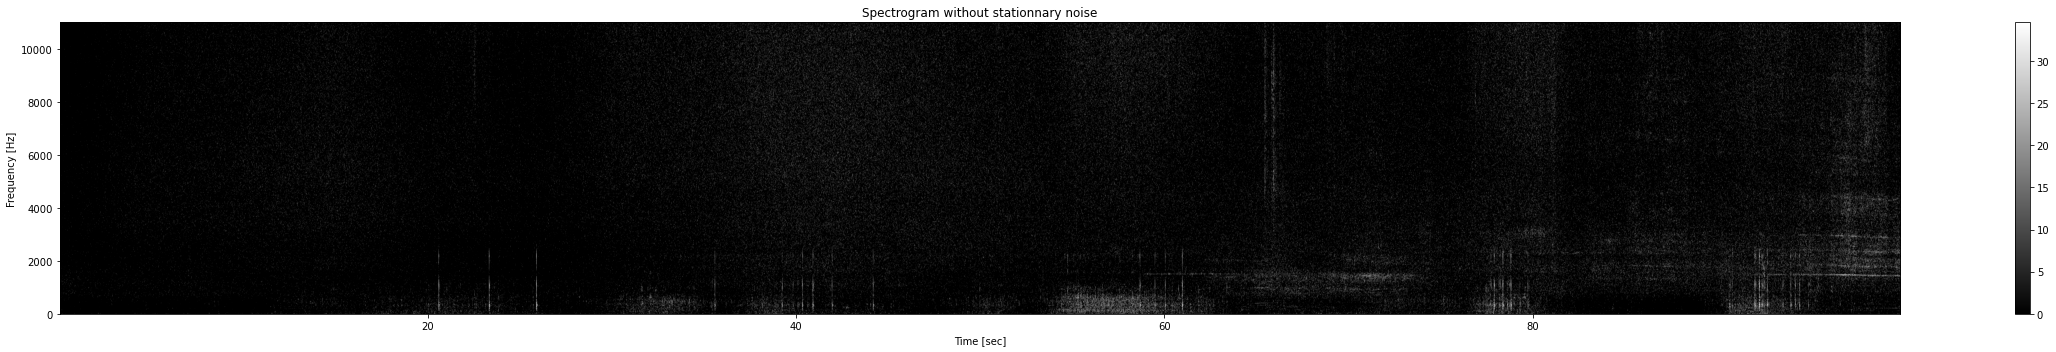

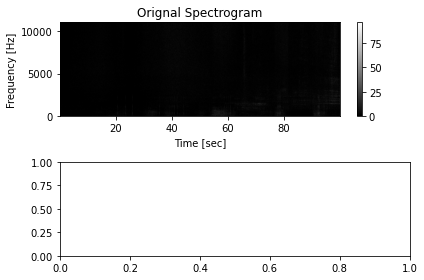

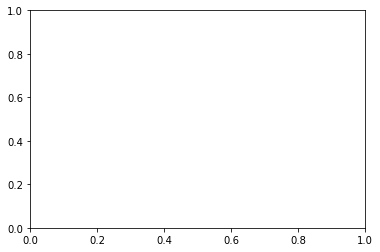

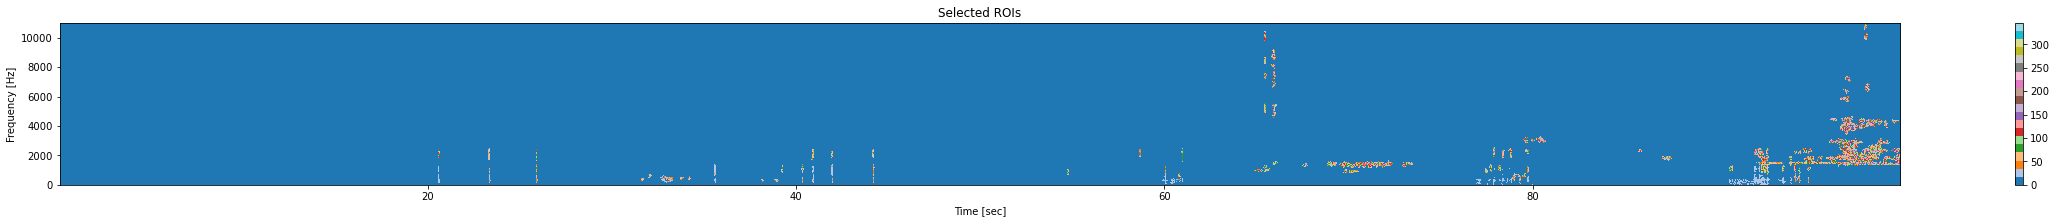

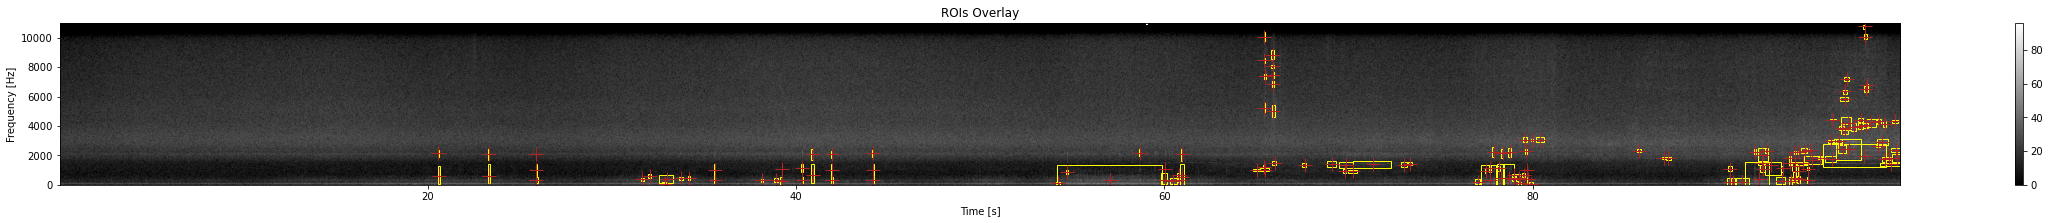

In [16]:
filenames = [
    # 'to_analyse/bugg/20220803_120904.wav',
    # 'to_analyse/moth/20220803_120904.wav'
    'false_colour_index_spectrogram/19700106_211624.WAV'
]

for i in filenames:
    # s, fs = sound.load('chirp4sub.wav')
    # s, fs = sound.load('to_analyse/moth/20220803_120904.wav')
    # s, fs = sound.load('to_analyse/bugg/20220803_120904.wav')
    s, fs = librosa.load(i, offset=3200, duration=100)

    dB_max = 96

    Sxx_power, tn, fn, ext = sound.spectrogram(s, fs, nperseg=1024, noverlap=1024//2)

    # Convert the power spectrogram into dB, add dB_max which is the maximum decibel
    # range when quantification bit is 16bits and display the result
    Sxx_db = power2dB(Sxx_power) + dB_max
    plot2d(Sxx_db, **{'vmin':0, 'vmax':dB_max, 'extent':ext})

    # First we remove the stationary background in order to increase the contrast [1]
    # Then we convert the spectrogram into dB
    Sxx_power_noNoise= sound.median_equalizer(Sxx_power, display=True, **{'extent':ext})
    Sxx_db_noNoise = power2dB(Sxx_power_noNoise)

    # Then we smooth the spectrogram in order to facilitate the creation of masks as
    # small sparse details are merged if they are close to each other
    Sxx_db_noNoise_smooth = sound.smooth(Sxx_db_noNoise, std=0.5,
                             display=True, savefig=None,
                             **{'vmin':0, 'vmax':dB_max, 'extent':ext})

    # Then we create a mask (i.e. binarization of the spectrogram) by using the
    # double thresholding technique
    im_mask = rois.create_mask(im=Sxx_db_noNoise_smooth, mode_bin ='relative',
                               bin_std=8, bin_per=0.5,
                               verbose=False, display=False)

    # Finaly, we put together pixels that belong to the same acoustic event, and
    # remove very small events (<=25 pixel²)
    im_rois, df_rois = rois.select_rois(im_mask, min_roi=25, max_roi=None,
                                     display= True,
                                     **{'extent':ext})

    # format dataframe df_rois in order to convert pixels into time and frequency
    df_rois = format_features(df_rois, tn, fn)

    # overlay bounding box on the original spectrogram
    ax0, fig0 = overlay_rois(Sxx_db, df_rois, **{'vmin':0, 'vmax':dB_max, 'extent':ext})

    # Compute and visualize centroids
    df_centroid = features.centroid_features(Sxx_db, df_rois, im_rois)
    df_centroid = format_features(df_centroid, tn, fn)
    ax0, fig0 = overlay_centroid(Sxx_db, df_centroid, savefig=None,
                                 **{'vmin':0,'vmax':dB_max,'extent':ext,'ms':14,
                                    'marker':'+', 'fig':fig0, 'ax':ax0})